# Tutorial: Route Planner

This tutorial demonstrates how the Route Planner package can be used to plan high-level routes for planning problems given in CommonRoad scenarios.

## 0. Preparation
* you have gone through the tutorial for **CommonRoad Input-Output**.
* you have installed the dependencies listed in **requirements.txt**.

Let's start with importing relevant modules and classes for setting up the automaton and the CommonRoad (CR) scenario.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

path_notebook = os.getcwd()
# add the root folder to python path
sys.path.append(os.path.join(path_notebook, "../"))

import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object

from route_planner.route_planner import RoutePlanner
from route_planner.utils_visualization import draw_route, get_plot_limits_from_reference_path, \
    get_plot_limits_from_routes

ImportError: cannot import name 'draw_route' from 'route_planner.utils_visualization' (/home/edmond/Softwares/commonroad/commonroad-route-planner-cps/tutorial/../route_planner/utils_visualization.py)

## 1. Loading CR Scenario and Planning Problem
In the next step, we load a CommonRoad scenario and its planning problem(s), for which the routes should be planned. The route planner handles **one planning problem** at a time, thus we need to manually specify which planning problem it should take care. In our case, we select the first planning problem in the planning problem set. The meaning of the symbols in a scenario are explained as follows:
* **Dot**: initial state of the planning problem projected onto the position domain
* **Blue rectangle**: dynamic obstacle
* **Yellow rectangle**: goal region projected onto the position domain

In [53]:
import numpy as np
ref_path = np.array([[0.25,0],[0.0,0],[0,1],[1,1],[1,0],[2,0],[2,1], [1.5, 1]])

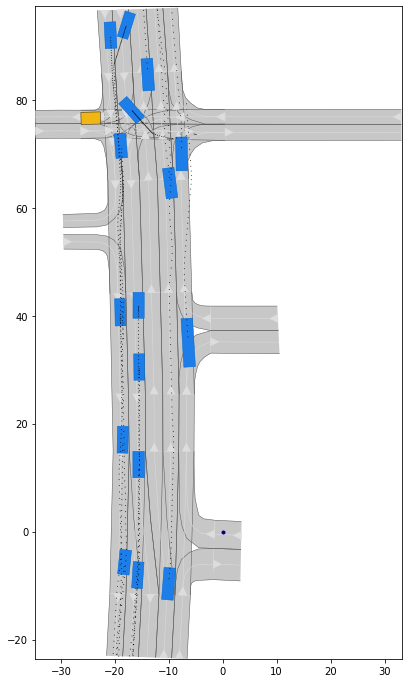

In [5]:
# load scenario
path_scenario = os.path.join(path_notebook, "../scenarios/")
id_scenario = 'USA_Peach-2_1_T-1'

# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
    
# plot the scenario and the planning problem set
plt.figure(figsize=(12, 12))
draw_object(scenario)
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.margins(0, 0)
plt.show()

## 2. Creating a route planner and planning for routes

### 2.1 Instantiation
A route planner can be easily constructed by passing the **scenario** and the **planning problem** to `RoutePlanner` object. As for the backend, there are currently three supported options:
1. NETWORKX: uses built-in functions from the networkx package, tends to change lane later
2. NETWORKX_REVERSED: uses built-in functions from the networkx package, tends to change lane earlier
3. PRIORITY_QUEUE: uses A-star search to find routes, lane change maneuver depends on the heuristic cost

### 2.2 Planning all possible routes
The route planner plans a route for all possible combinations of start / goal lanelets. E.g. if our initial state is located in two lanes (due to overlapping of lanelets), and the same for our goal state, the route planner will try to plan routes for the four possible combinations.

### 2.3 Retrieving a route
Planned routes can be retrieved by using simple indices, or based on some heuristic functions to determine the best route of all. A route consists of a list of lanelet ids that leads from the initial state to the goal state.

### 2.4 Retrieving reference path
A reference path is automatically generated for each planned routes. The center lines of lanelets of a route is used to construct the reference path. The resulting polyline is then smoothened with Chaikin's corner cutting algorithm.

In [6]:
# instantiate a route planner
route_planner = RoutePlanner(scenario, planning_problem, backend=RoutePlanner.Backend.NETWORKX_REVERSED)

# plan routes, and save the found routes in a route candidate holder
candidate_holder = route_planner.plan_routes()

# retrieving routes
# option 1: retrieve all routes
list_routes, num_route_candidates = candidate_holder.retrieve_all_routes()
print(f"Feasible route candidates: {num_route_candidates}")

# we retrieve the first route in the list
# this is equivalent to: route = list_routes[0]
route = candidate_holder.retrieve_first_route()

# option 2: retrieve the best route by orientation metric
# route = candidate_holder.retrieve_best_route_by_orientation()

# print out coordinates of the vertices of the reference path
print("\nCoordinates [x, y]:")
print(route.reference_path)

Feasible route candidates: 2

Coordiantes [x, y]:
[[  3.438       -0.70515   ]
 [  1.43974771  -0.62155698]
 [ -5.23727952   0.65236778]
 [ -6.07558033   2.40798844]
 [ -6.45699478   4.37016582]
 [ -6.60847299   6.35885305]
 [ -6.65768315   8.35824755]
 [ -6.68959649  10.35795301]
 [ -6.72997919  16.90656852]
 [ -6.71875837  18.90653705]
 [ -6.70754374  20.9065056 ]
 [ -6.69634044  22.90647423]
 [-13.31858384  48.30042973]
 [-13.37187576  50.2997196 ]
 [-13.42516768  52.29900947]
 [-13.4784596   54.29829933]
 [-13.53174446  56.29758939]
 [-13.58502731  58.2968795 ]
 [-13.63831017  60.29616961]
 [-13.92210613  67.169631  ]
 [-14.0755906   69.1637326 ]
 [-14.7487828   74.78720713]
 [-15.99782677  76.27590479]
 [-17.91290691  76.7975897 ]
 [-19.90843873  76.89027351]
 [-23.98248473  76.9140069 ]
 [-28.33757091  76.89718618]
 [-30.33749316  76.90998311]
 [-32.33742335  76.89327184]]


## 3. Visualizing planning results

The planned routes can be easily visualized with the `draw_route` function. The arguements `draw_route_lanelets` and `draw_reference_path` indicates whether the lanelets of the route and the reference path should be drawn, respectively. The lanelets of the route is colored in cyan.

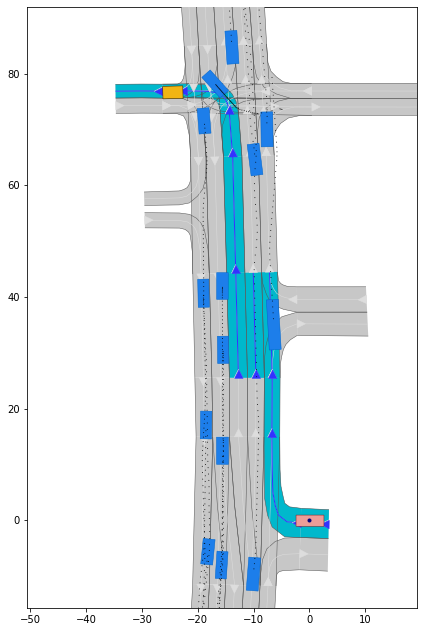

In [7]:
# retrieve plot limits for better visualization. 
# option 1: plot limits from reference path
# plot_limits = get_plot_limits_from_reference_path(route)

# option 2: plot limits from lanelets in the route
plot_limits = get_plot_limits_from_routes(route)

# determine the figure size for better visualization
size_x = 7
ratio_x_y = (plot_limits[1] - plot_limits[0]) / (plot_limits[3] - plot_limits[2])
fig = plt.figure(figsize=(size_x, size_x / ratio_x_y))
fig.gca().axis('equal')

draw_route(route, draw_route_lanelets=True, draw_reference_path=False, plot_limits=plot_limits)

We now plot the generated reference path as well, which is colored in magenta.

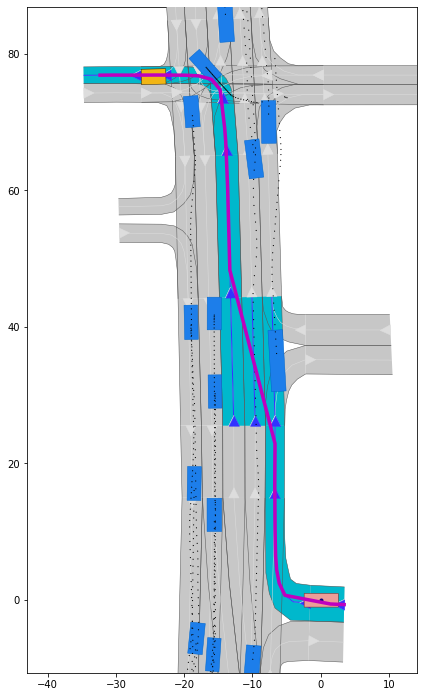

In [8]:
# retrieve plot limits for better visualization. 
# option 1: plot limits from reference path
plot_limits = get_plot_limits_from_reference_path(route)
# option 2: plot limits from lanelets in the route
# plot_limits = get_plot_limits_from_routes(route)

# determine the figure size for better visualization
size_x = 7
ratio_x_y = (plot_limits[1] - plot_limits[0]) / (plot_limits[3] - plot_limits[2])
fig = plt.figure(figsize=(size_x, size_x / ratio_x_y))
fig.gca().axis('equal')

draw_route(route, draw_route_lanelets=True, draw_reference_path=True, plot_limits=plot_limits)

Number of route candidates: 2


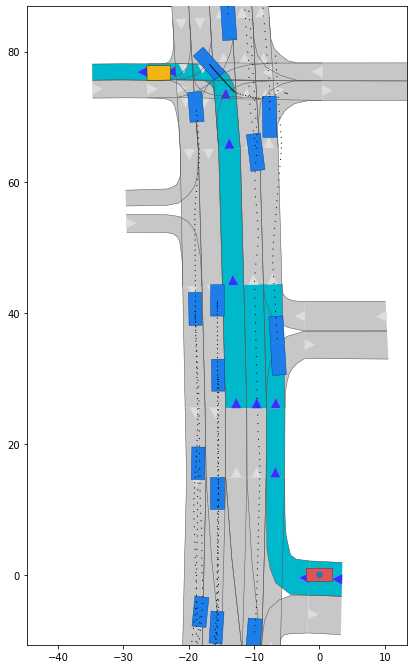

In [12]:
import os
import sys

path_notebook = os.getcwd()
# add the root folder to python path
sys.path.append(os.path.join(path_notebook, "../"))

import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

from route_planner.route_planner import RoutePlanner
from route_planner.utils_visualization import visualize_route, obtain_plot_limits_from_reference_path


# ========== initialization =========== #
path_scenarios = os.path.join(os.getcwd(), "../scenarios/")
id_scenario = 'USA_Peach-2_1_T-1'
# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(f"{path_scenarios}{id_scenario}.xml").open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

# ========== route planning =========== #
# instantiate a route planner with the scenario and the planning problem
route_planner = RoutePlanner(scenario, planning_problem, backend=RoutePlanner.Backend.NETWORKX_REVERSED)
# plan routes, and save the routes in a route candidate holder
candidate_holder = route_planner.plan_routes()

# ========== retrieving routes =========== #
# option 1: retrieve all routes
list_routes, num_route_candidates = candidate_holder.retrieve_all_routes()
print(f"Number of route candidates: {num_route_candidates}")
# here we retrieve the first route in the list, this is equivalent to: route = list_routes[0]
route = candidate_holder.retrieve_first_route()

# option 2: retrieve the best route by orientation metric
# route = candidate_holder.retrieve_best_route_by_orientation()

# ========== visualization =========== #
visualize_route(route, draw_route_lanelets=True, draw_reference_path=True, size_x = 7)
